In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

! unzip cats_and_dogs_filtered.zip

--2022-10-15 16:54:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   205MB/s    in 0.3s    

2022-10-15 16:54:08 (205 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog

In [3]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout
from keras import backend as K
import keras
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import MaxPool2D
from google.colab.patches import cv2_imshow

In [4]:
train_path="/content/cats_and_dogs_filtered/train"
test_path="/content/cats_and_dogs_filtered/validation"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

print(class_names)
print(class_names_test)

['cats', 'dogs']
['cats', 'dogs']


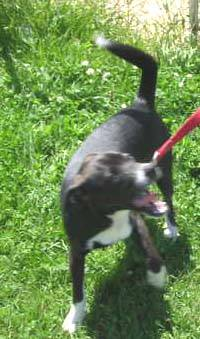

In [5]:
image_dog=cv2.imread("/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg")
cv2_imshow(image_dog)


In [6]:
train_datagen = ImageDataGenerator(
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15)


test_datagen = ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow_from_directory("/content/cats_and_dogs_filtered/train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
test_generator = test_datagen.flow_from_directory("/content/cats_and_dogs_filtered/validation",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))

    model.add(Flatten(name='flatten'))
    
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    return model

In [10]:
model=VGG16()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
# Vgg16 = Model(inputs=model.input, outputs=model.get_layer('vgg16').output)

In [11]:

opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [12]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [13]:
mc = ModelCheckpoint('/content/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [14]:
H = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    verbose=1,
    callbacks=[mc,es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
63/63 [==============================] - 56s 653ms/step - loss: 0.6946 - accuracy: 0.5105 - val_loss: 0.6858 - val_accuracy: 0.5470
Epoch 2/10
63/63 [==============================] - 38s 594ms/step - loss: 0.6844 - accuracy: 0.5530 - val_loss: 0.6760 - val_accuracy: 0.5800
Epoch 3/10
63/63 [==============================] - 38s 600ms/step - loss: 0.6820 - accuracy: 0.5545 - val_loss: 0.6708 - val_accuracy: 0.6210
Epoch 4/10
63/63 [==============================] - 38s 597ms/step - loss: 0.6839 - accuracy: 0.5545 - val_loss: 0.6834 - val_accuracy: 0.5220
Epoch 5/10
63/63 [==============================] - 38s 601ms/step - loss: 0.6751 - accuracy: 0.5785 - val_loss: 0.6797 - val_accuracy: 0.5370
Epoch 6/10
63/63 [==============================] - 38s 598ms/step - loss: 0.6744 - accuracy: 0.5725 - val_loss: 0.6615 - val_accuracy: 0.6170
Epoch 7/10
63/63 [==============================] - 39s 610ms/step - loss: 0.6612 - accuracy: 0.6105 - val_loss: 0.6465 - val_accuracy: 0.6310

In [15]:
model.load_weights("/content/best_model.h5")

In [16]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.6273874044418335, 0.6610000133514404]

In [17]:
model_json = model.to_json()
with open("/content/model.json","w") as json_file:
  json_file.write(model_json)

In [35]:
from keras.models import model_from_json

def predict_(image_path):
    #Ler o modelo-salvo
    json_file = open('/content/model.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)

    #Ler os pesos
    model_c.load_weights("/content/best_model.h5")

    #Compilar os modelo
    opt = SGD(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


    #Ler a imagem desejada para classificacao
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    cv2_imshow(image)

    #Predicao
    preds = model_c.predict(np.expand_dims(image, axis=0))
    print(preds)
    if preds < 0.5:
        print("Predicted Label:Cat")
    else:
        print("Predicted Label: Dog")

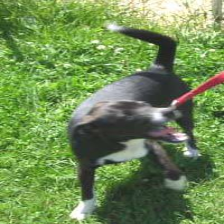

1/1 [==============================] - 0s 136ms/step
[[0.66793376]]
Predicted Label: Dog


In [37]:
predict_("/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg")